In [1]:
import scarches
from scarches.models.scpoli import scPoli
import torch

import hnoca.map as mapping

import gc
import anndata
import pandas as pd
import numpy as np
import scanpy as sc
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sc.set_figure_params(dpi_save=300, dpi=150)
sc.settings.figdir = "/storage/data/2404_revision/hnoca_ce_figures/"

# Loading query data

In [3]:
adata_ref_hvg = anndata.read_h5ad("/storage/data/final_adata_object_export/hnoca_cleanedmeta_hvg.h5ad")

In [46]:
basepath = "/storage/data/2404_revision/ce_data"

adata_query_v1 = anndata.concat({
    "ce_wang2024":anndata.read_h5ad(f"{basepath}/gage_data/gage.h5ad"),
    "ce_bertucci2023": anndata.read_h5ad(f"{basepath}/bowles_data/bowles.h5ad"),
    "ce_caporale2023": anndata.read_h5ad(f"{basepath}/testa_data/testa_mosaic.h5ad"),
    "ce_lopeztobon2023": anndata.read_h5ad(f"{basepath}/testa_data/testa_ndd.h5ad"),
    "ce_dony2024": anndata.read_h5ad(f"{basepath}/binder_data/binder.h5ad"),
}, join="outer", index_unique="_")

In [47]:
adata_query_v1

AnnData object with n_obs × n_vars = 200504 × 36842
    obs: 'sample_source', 'organism', 'disease', 'cell_line_original', 'organoid_age_days', 'batch', 'treatment', 'cell_type_original', 'suspension_type', 'organ', 'assay_sc', 'ethnicity', 'sex', 'development_stage', 'cell_type', 'obs_names_original', 'publication', 'doi', 'hnoca_core'
    layers: 'counts_lengthnorm'

In [6]:
adata_ref_hvg.obs["snapseed_pca_rss_level_1"] = "unknown"
adata_ref_hvg.obs["snapseed_pca_rss_level_12"] = "unknown"
adata_ref_hvg.obs["snapseed_pca_rss_level_123"] = "unknown"

adata_query_v1_hvg = adata_query_v1[:, adata_ref_hvg.var_names].copy()
adata_query_v1_hvg.obs["snapseed_pca_rss_level_1"] = "unknown"
adata_query_v1_hvg.obs["snapseed_pca_rss_level_12"] = "unknown"
adata_query_v1_hvg.obs["snapseed_pca_rss_level_123"] = "unknown"

# Mapping to HNOCA

In [16]:
reference_model = scPoli.load("/storage/data/organoid_atlas_adatas/230510_data/scpoli_hierarchical123/", adata_ref_hvg, map_location=torch.device("cuda"))
mapper = mapping.AtlasMapper(reference_model)

AnnData object with n_obs × n_vars = 1770578 × 3000
    obs: 'assay_differentiation', 'assay_sc', 'assay_sc_original', 'assay_type_differentiation', 'bio_sample', 'cell_line', 'cell_line_original', 'cell_type', 'cell_type_original', 'development_stage', 'development_stage_original', 'disease', 'disease_original', 'ethnicity', 'ethnicity_original', 'gm', 'id', 'individual', 'organ', 'organ_original', 'organism', 'organism_original', 'sample_source', 'sex', 'sex_original', 'source_doi', 'state_exact', 'suspension_type', 'suspension_type_original', 'tech_sample', 'treatment', 'organoid_age_days', 'publication', 'doi', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'annot_level_1', 'annot_level_2', 'annot_level_3_rev2', 'annot_level_4_rev2', 'annot_region_rev2', 'annot_ntt_rev2', 'Hallmark_Glycolysis', 'snapseed_pca_rss_level_1', 'snapseed_pca_rss_level_12', 'snapseed_pca_rss_level_

In [17]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_loss",
    "mode": "min",
    "threshold": 0,
    "patience": 10,
    "reduce_lr": True,
    "lr_patience": 5,
    "lr_factor": 0.1,
}

mapper.map_query(
    adata_query_v1_hvg,
    retrain="partial",
    max_epochs=20,
    batch_size=256,
    unlabeled_prototype_training=False,
    n_epochs=10,
    pretraining_epochs=9,
    early_stopping_kwargs=early_stopping_kwargs,
    eta=10,
    alpha_epoch_anneal=10,
)

mapper.query_model.save("/storage/data/2404_revision/ce_output/240619_scpoli_extended_v1")

INFO:scarches.trainers.scpoli.trainer:GPU available: True, GPU used: True


Embedding dictionary:
 	Num conditions: [460]
 	Embedding dim: [5]
Encoder Architecture:
	Input Layer in, out and cond: 3000 1024 5
	Mean/Var Layer in/out: 1024 10
Decoder Architecture:
	First Layer in, out and cond:  10 1024 5
	Output Layer in/out:  1024 3000 

The missing labels are: {'unknown'}
Therefore integer value of those labels is set to -1
The missing labels are: {'unknown'}
Therefore integer value of those labels is set to -1
The missing labels are: {'unknown'}
Therefore integer value of those labels is set to -1
The missing labels are: {'unknown'}
Therefore integer value of those labels is set to -1
The missing labels are: {'unknown'}
Therefore integer value of those labels is set to -1
The missing labels are: {'unknown'}
Therefore integer value of those labels is set to -1
The missing labels are: {'unknown'}
Therefore integer value of those labels is set to -1
The missing labels are: {'unknown'}
Therefore integer value of those labels is set to -1
The missing labels are: {

In [18]:
mapper.compute_wknn(k=100)
labels1 = mapper.transfer_labels("annot_level_2")

Info: GPU detected and cuml installed. Use cuML for neighborhood estimation.
Info: GPU detected and cuml installed. Use cuML for neighborhood estimation.


# Load giandomenico data and train

In [ ]:
adata_gd = sc.read_h5ad('/storage/data/2404_revision/ce_data/giandomenico_data/giandomenico.h5ad')
adata_gd.obs_names = adata_gd.obs_names + "_ce_giandomenico2019"

In [ ]:
adata_gd_hvg = adata_gd[:, adata_ref_hvg.var_names].copy()
adata_gd_hvg.obs["snapseed_pca_rss_level_1"] = "unknown"
adata_gd_hvg.obs["snapseed_pca_rss_level_12"] = "unknown"
adata_gd_hvg.obs["snapseed_pca_rss_level_123"] = "unknown"

In [46]:
mapper2 = mapping.AtlasMapper(mapper.query_model)

mapper2.map_query(
    adata_gd_hvg,
    retrain="partial",
    max_epochs=20,
    batch_size=256,
    unlabeled_prototype_training=False,
    n_epochs=20,
    pretraining_epochs=18,
    early_stopping_kwargs=early_stopping_kwargs,
    eta=10,
    alpha_epoch_anneal=10,
)

mapper.query_model.save("/storage/data/2404_revision/ce_output/240731_scpoli_extended_v2")

INFO:scarches.trainers.scpoli.trainer:GPU available: False


Initializing dataloaders
Starting training
 |████████████████████| 100.0%  - val_loss:  719.05 - val_cvae_loss:  719.05 - val_prototype_loss:    0.00 - val_unlabeled_loss:    0.00


In [18]:
mapper2.compute_wknn(k=100)
labels2 = mapper2.transfer_labels("annot_level_2")

Info: GPU detected and cuml installed. Use cuML for neighborhood estimation.
Info: GPU detected and cuml installed. Use cuML for neighborhood estimation.


# Project full atlas

In [ ]:
adata_ref_hvg.obs["hnoca_core"] = False
adata_ref_hvg.obs["annot_level_2_query"] = np.nan
adata_query_v1_hvg.obs["annot_level_2_query"] = labels1["best_label"]
adata_gd_hvg.obs["annot_level_2_query"] = labels2["best_label"]

adata_joint = anndata.concat([adata_ref_hvg, adata_query_v1_hvg, adata_gd_hvg])
adata_joint.X = adata_joint.layers["counts_lengthnorm"].copy()

In [ ]:
adata_joint.obsm["X_scpoli"] = mapper2.query_model.get_latent(adata_joint, mean=True)
sc.pp.neighbors(adata_joint, use_rep = "X_scpoli", key_added="knn_scpoli")
adata_joint.obsm["X_umap_scpoli"] = sc.tl.umap(adata_joint, neighbors_key="knn_scpoli", copy=True).obsm["X_umap"]

In [17]:
adata_joint

AnnData object with n_obs × n_vars = 1984362 × 3000
    obs: 'assay_sc', 'cell_line_original', 'cell_type', 'cell_type_original', 'development_stage', 'disease', 'ethnicity', 'organ', 'organism', 'sample_source', 'sex', 'suspension_type', 'treatment', 'obs_names_original', 'organoid_age_days', 'publication', 'doi', 'batch', 'snapseed_pca_rss_level_1', 'snapseed_pca_rss_level_12', 'snapseed_pca_rss_level_123', 'hnoca_core', 'annot_level_2_query'
    obsm: 'X_scpoli', 'X_umap_scpoli'
    layers: 'counts_lengthnorm'
    obsp: 'knn_scpoli_connectivities', 'knn_scpoli_distances'

# Plotting

In [21]:
colormap_l2 = {
    'PSC': '#fee8c8',
    'Neuroepithelium': '#fee0d2',
    'Dorsal Telencephalic NPC': '#9ecae1',
    'Ventral Telencephalic NPC': '#bcbddc',
    'Non-telencephalic NPC': '#fcbba1',
    'Dorsal Telencephalic IP': '#6baed6',
    'Dorsal Telencephalic Neuron': '#4292c6',
    'Ventral Telencephalic Neuron': '#9e9ac8',
    'Non-telencephalic Neuron': '#fb6a4a',
    'Glioblast': '#addd8e',
    'Astrocyte': '#31a354',
    'OPC': '#005a32',
    'CP': '#fdbb84',
    'Microglia': '#303030',
    'NC Derivatives': '#bdbdbd',
    'EC': '#696969',
    'MC': '#909090',
}

/home/ubuntu/venv/organoids/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


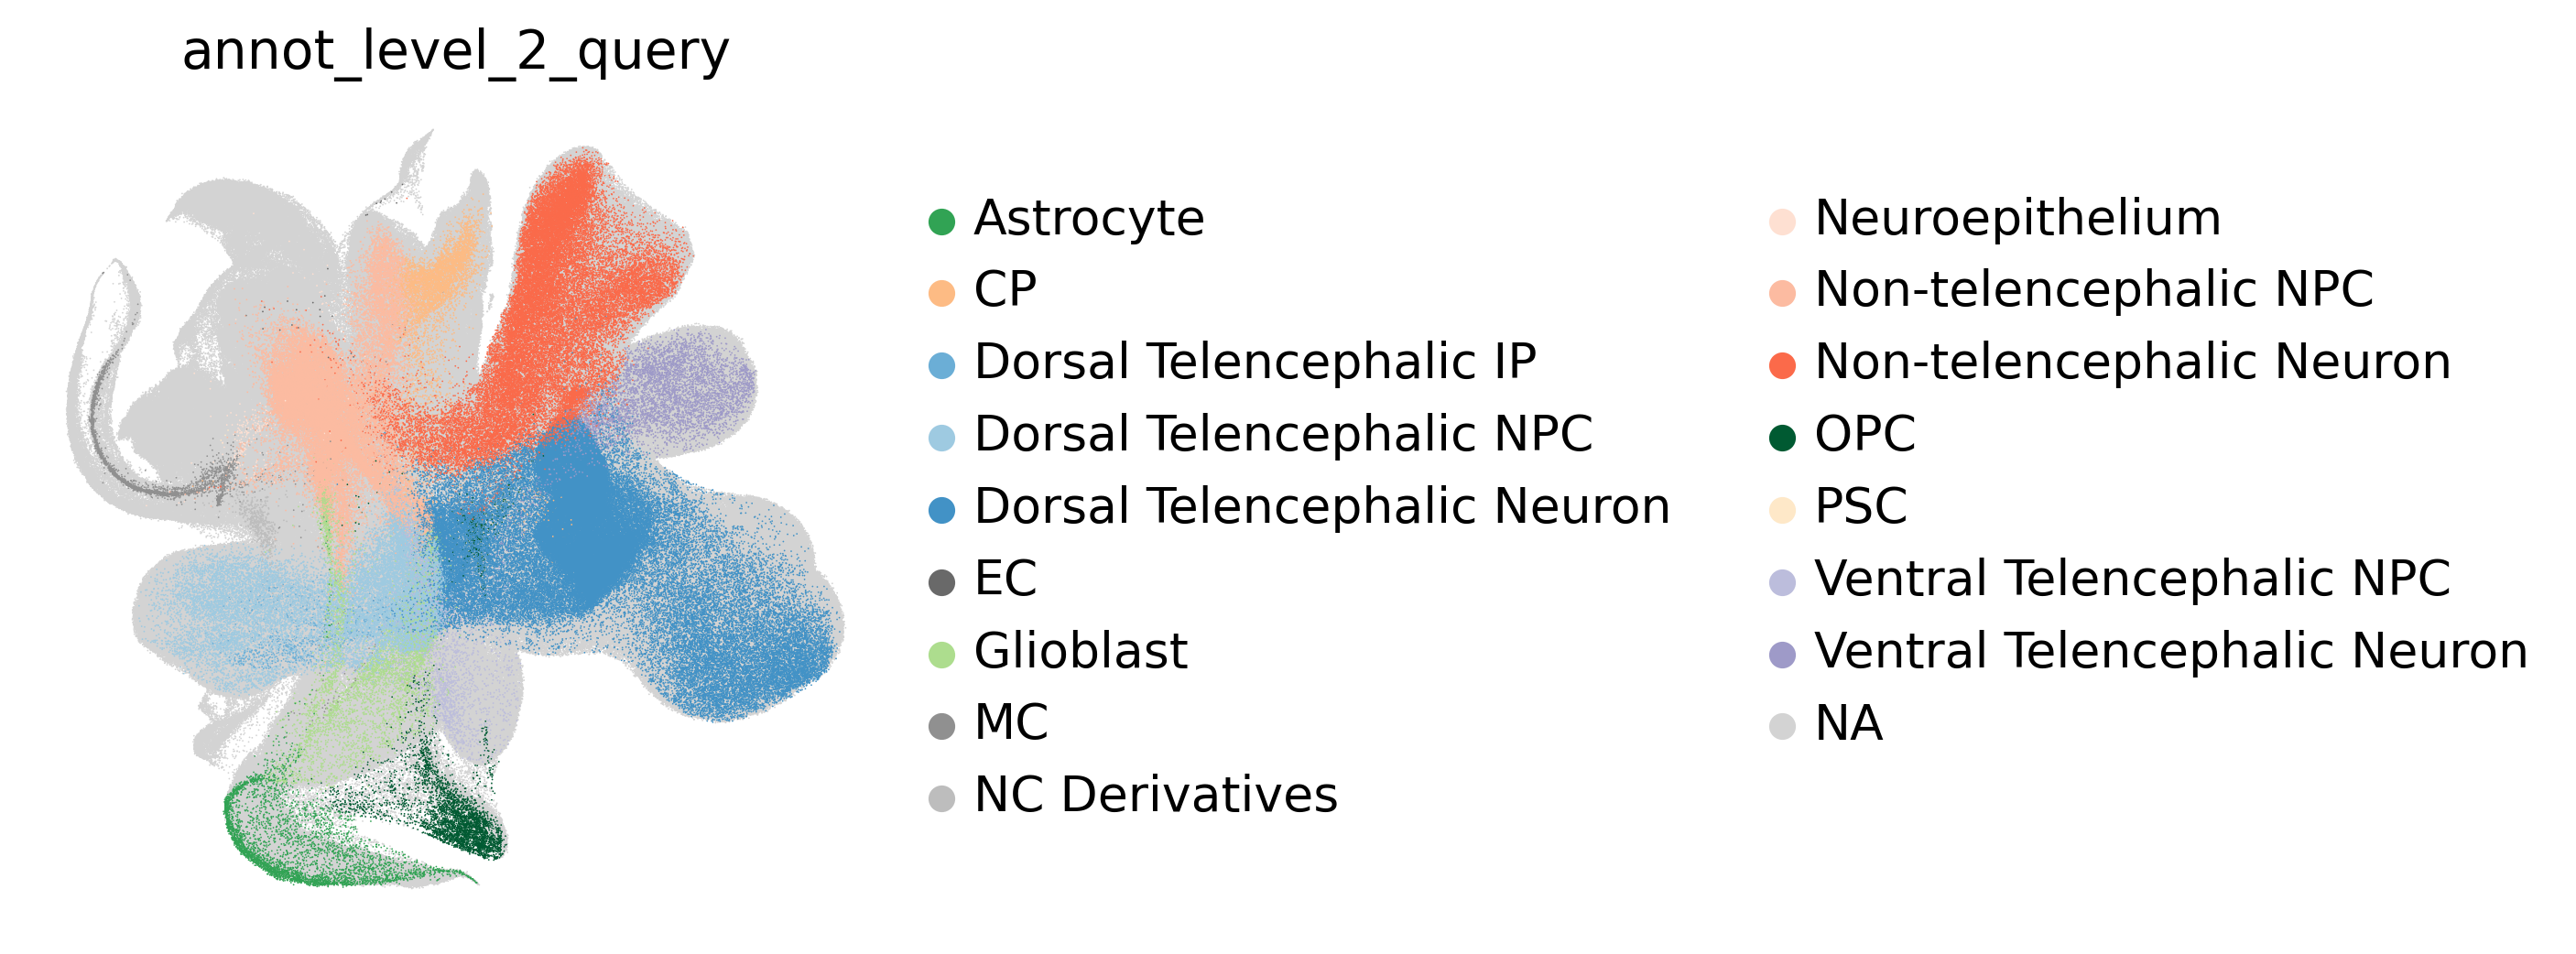

In [35]:
l2pal = [colormap_l2[i] for i in adata_joint.obs["annot_level_2_query"].cat.categories]
sc.pl.embedding(adata_joint, basis="X_umap_scpoli", color="annot_level_2_query", size=0.7, palette=l2pal, frameon=False)

In [ ]:
newpubs = ["Giandomenico, 2019", "Bertucci, 2023", "Caporale, 2023", "Lopez-Tobon, 2023", "Dony, 2024", "Wang, 2024"]

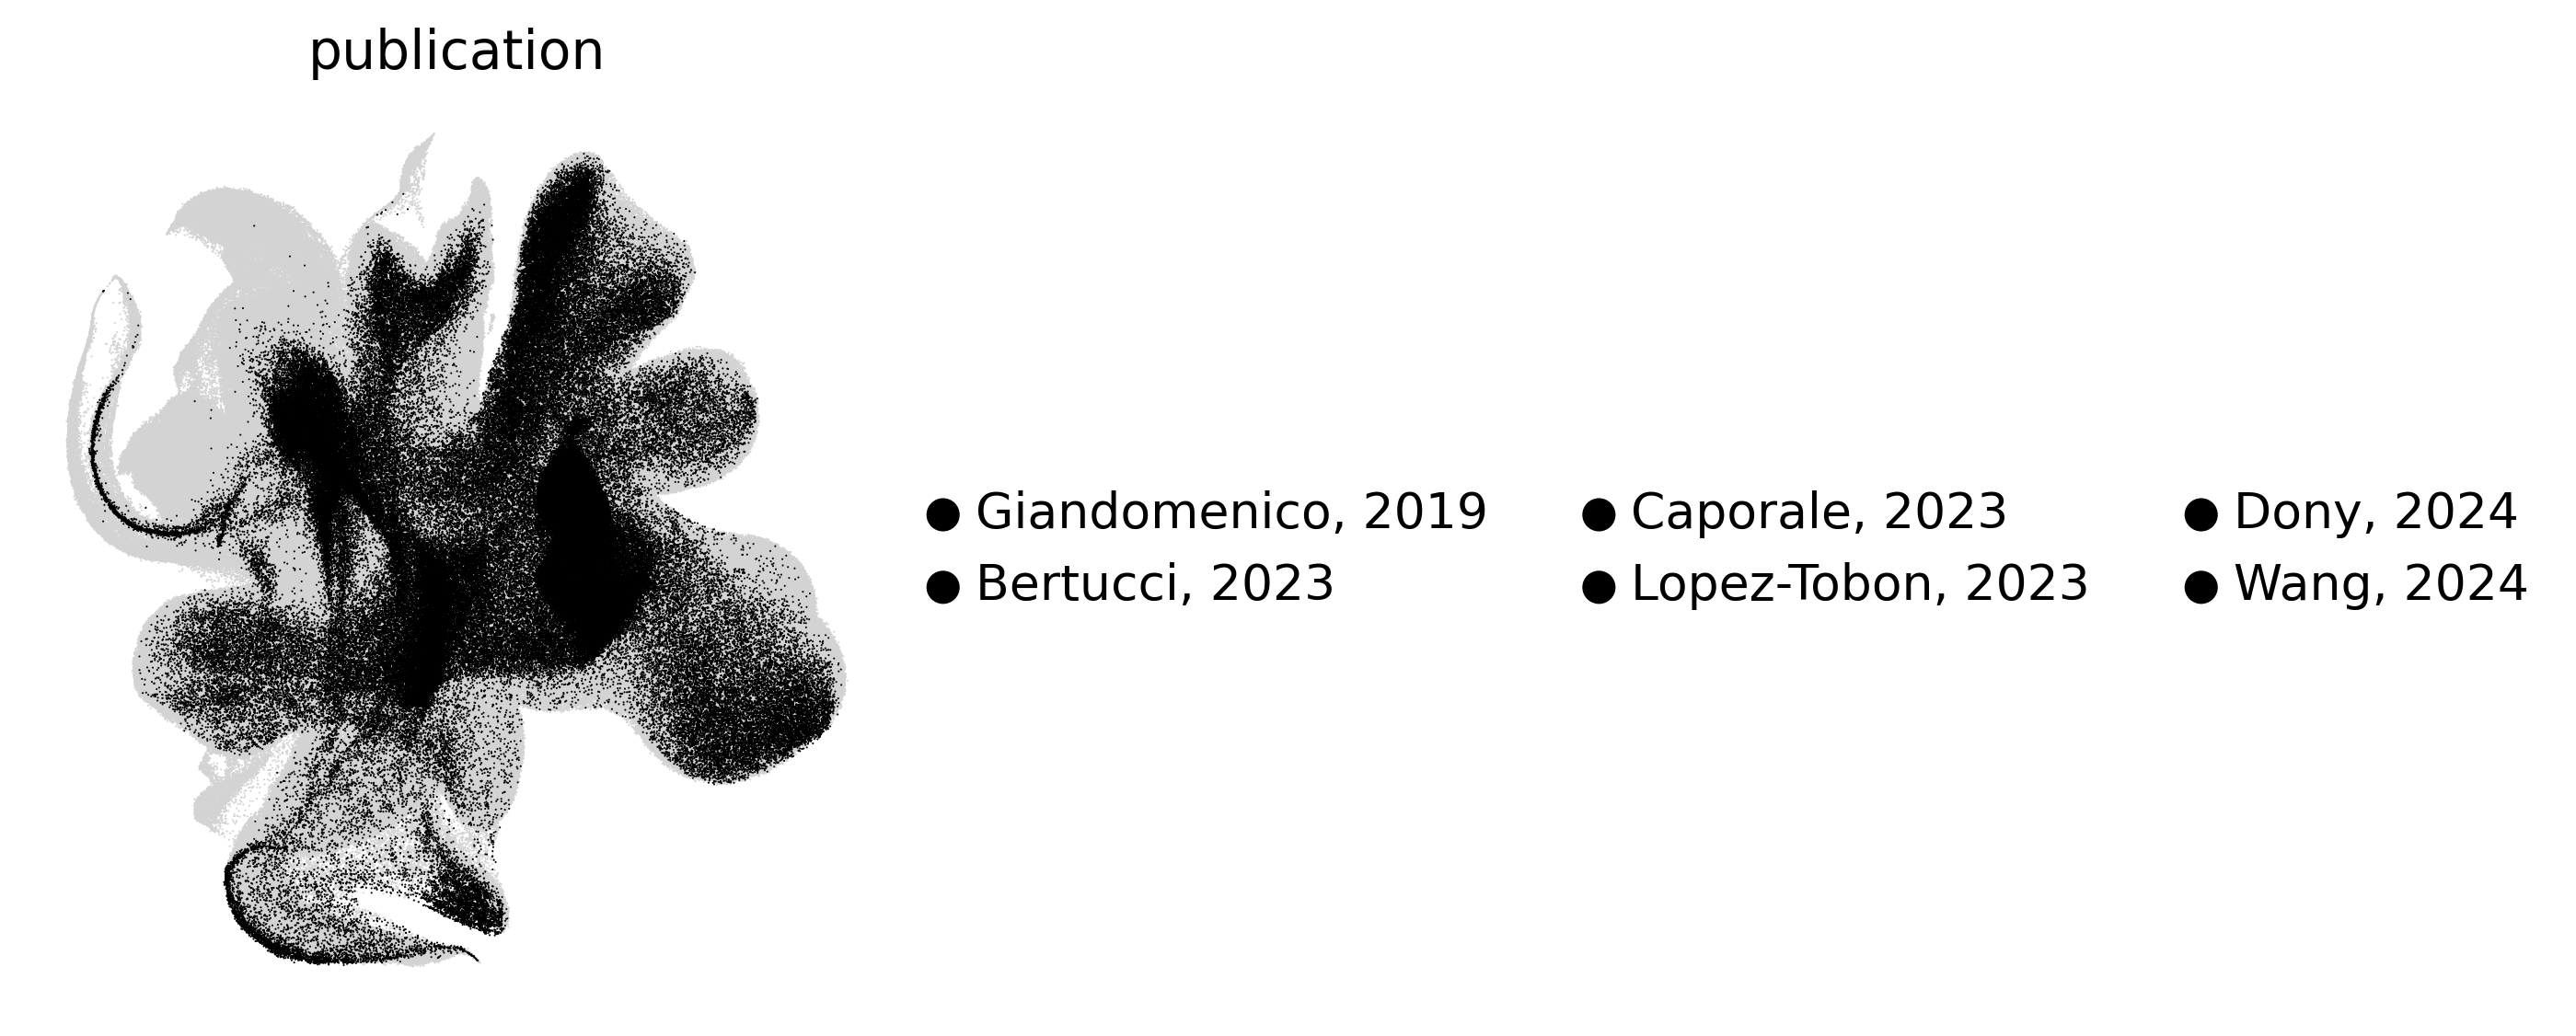

In [31]:
sc.pl.scatter(adata_joint, basis="umap_scpoli", color="publication", groups=newpubs, size=1.0, palette=["#000000"], frameon=False)

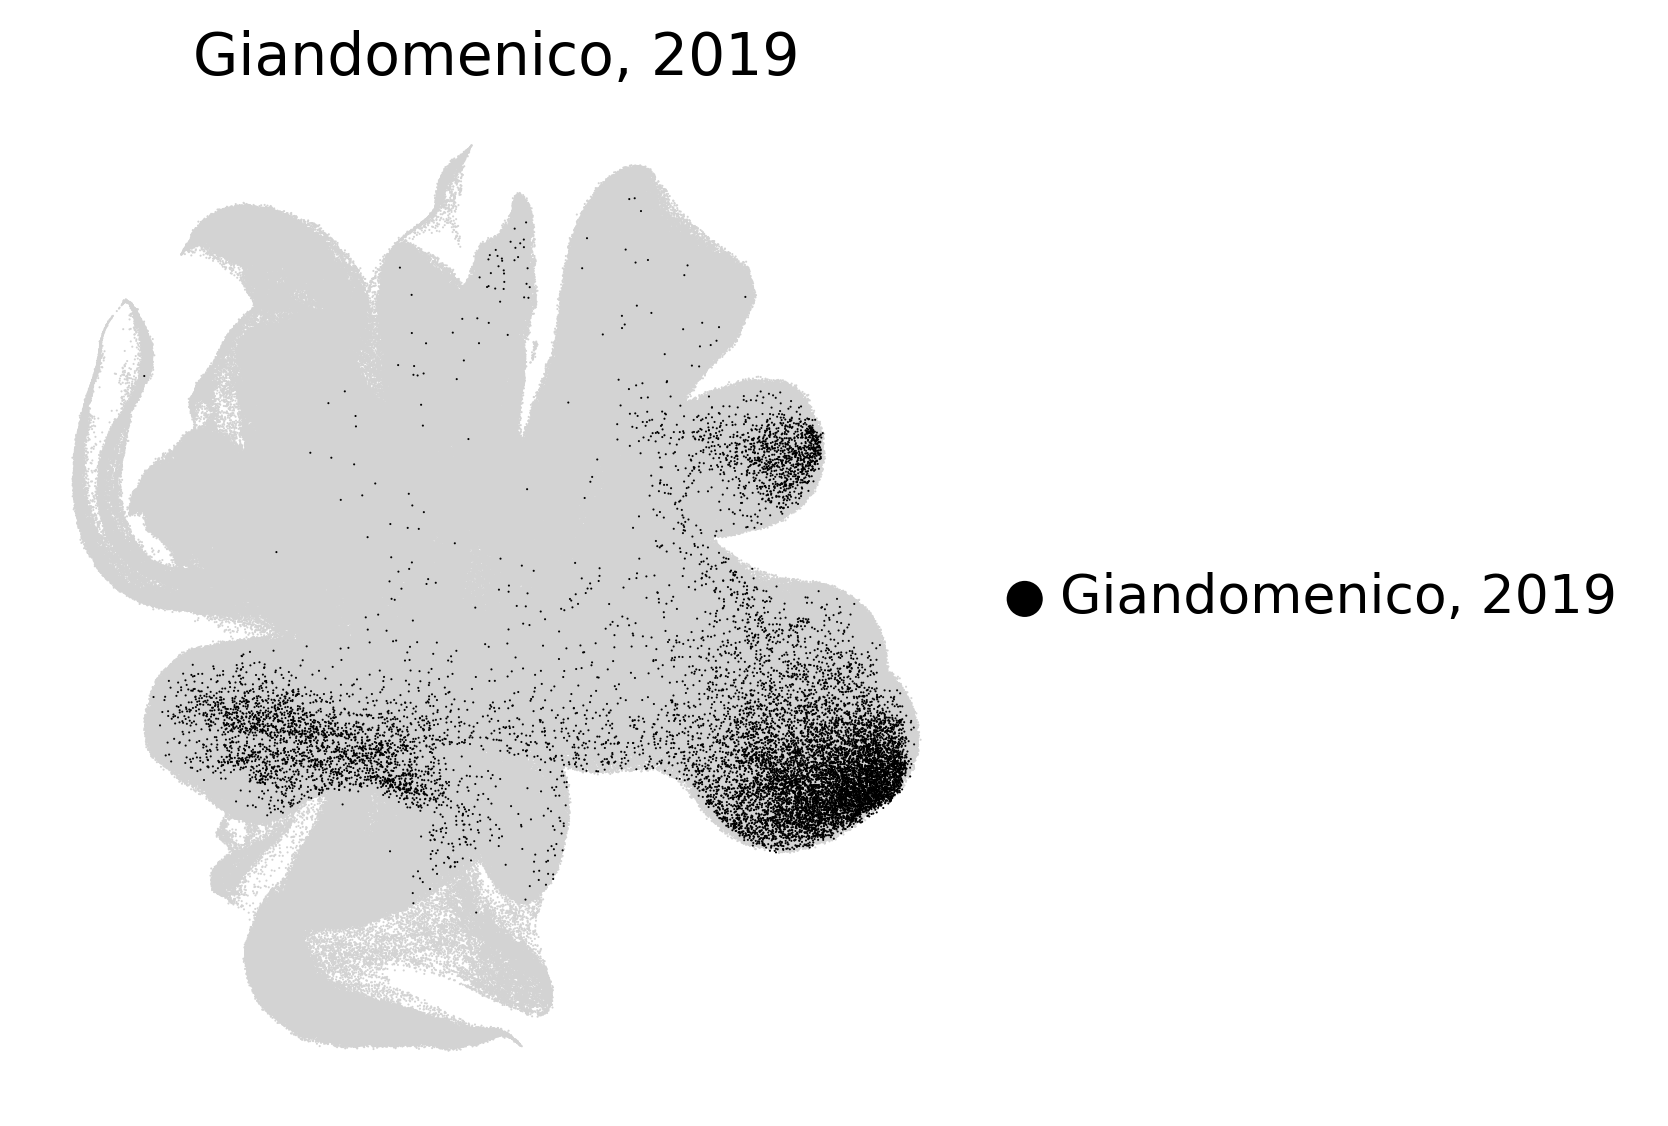

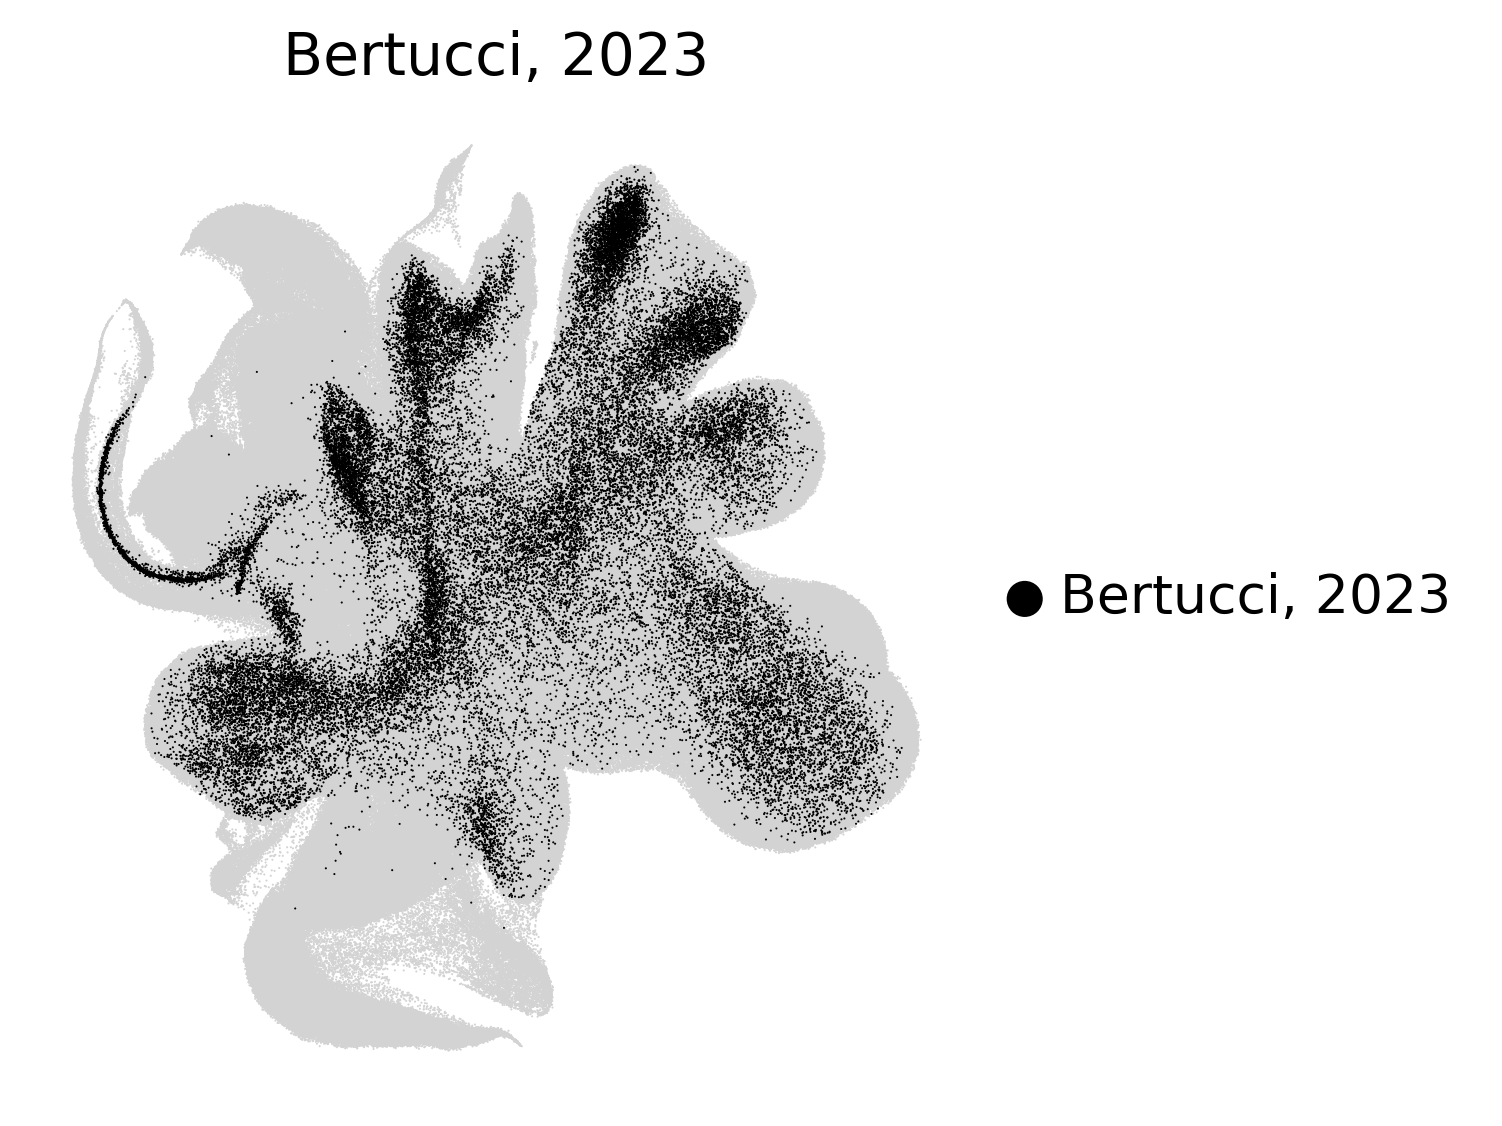

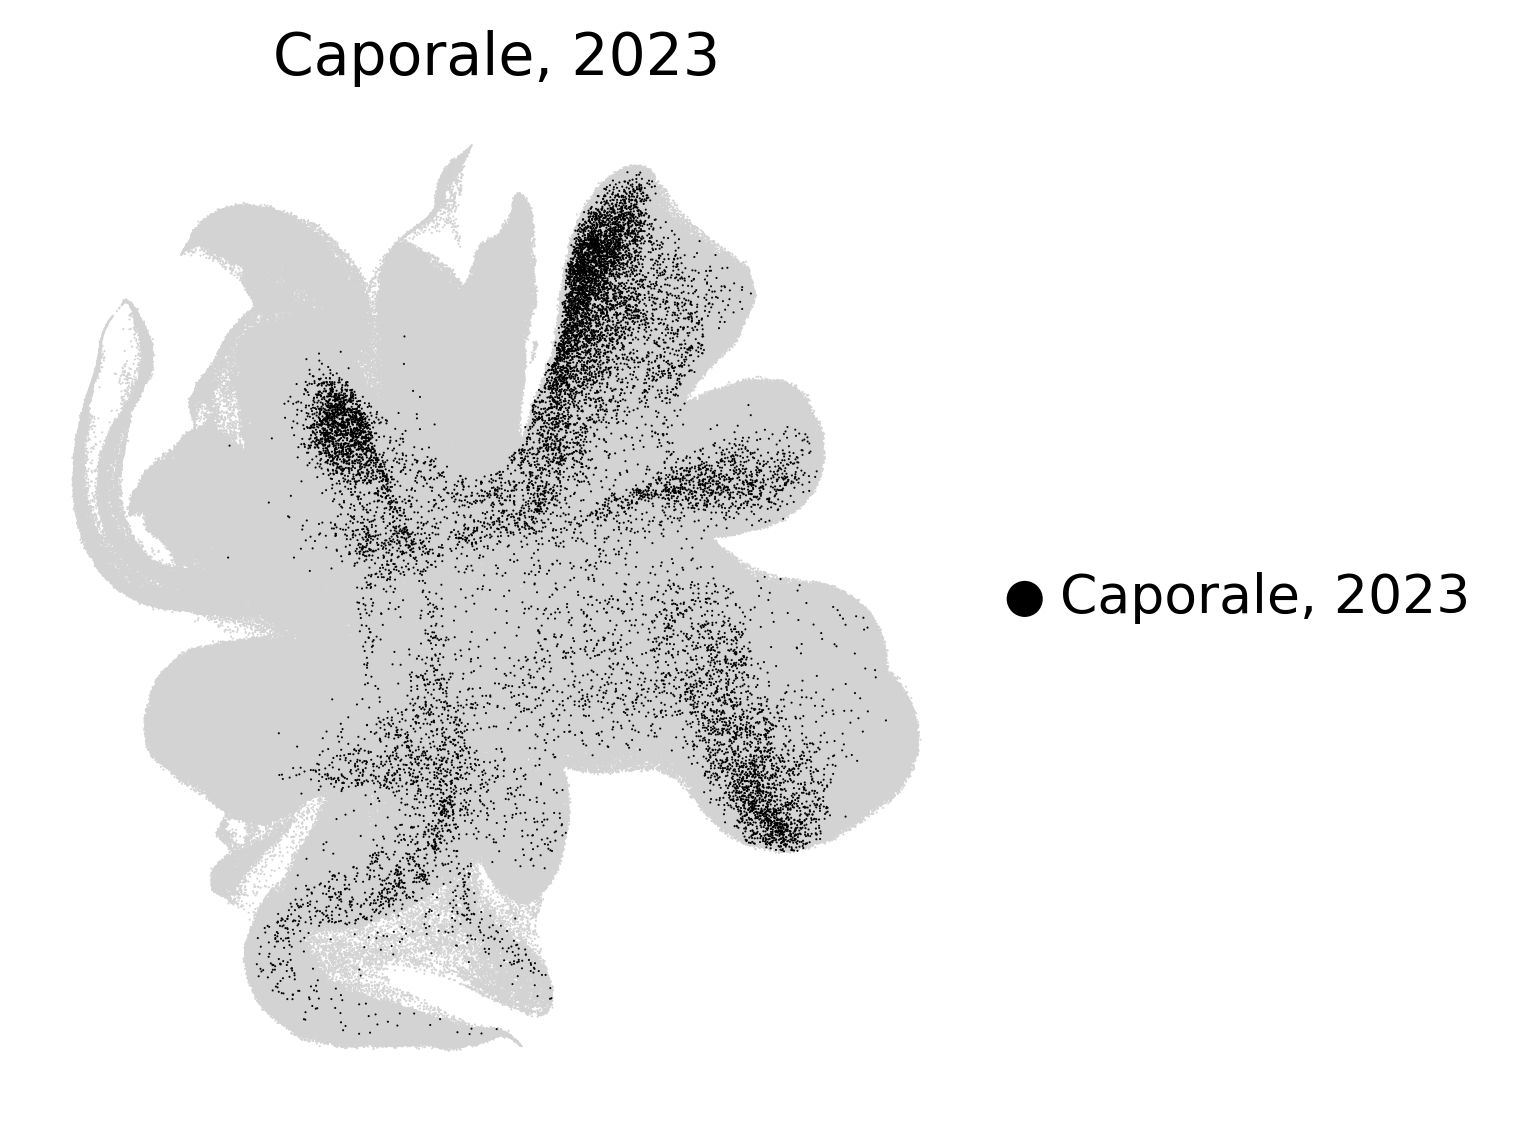

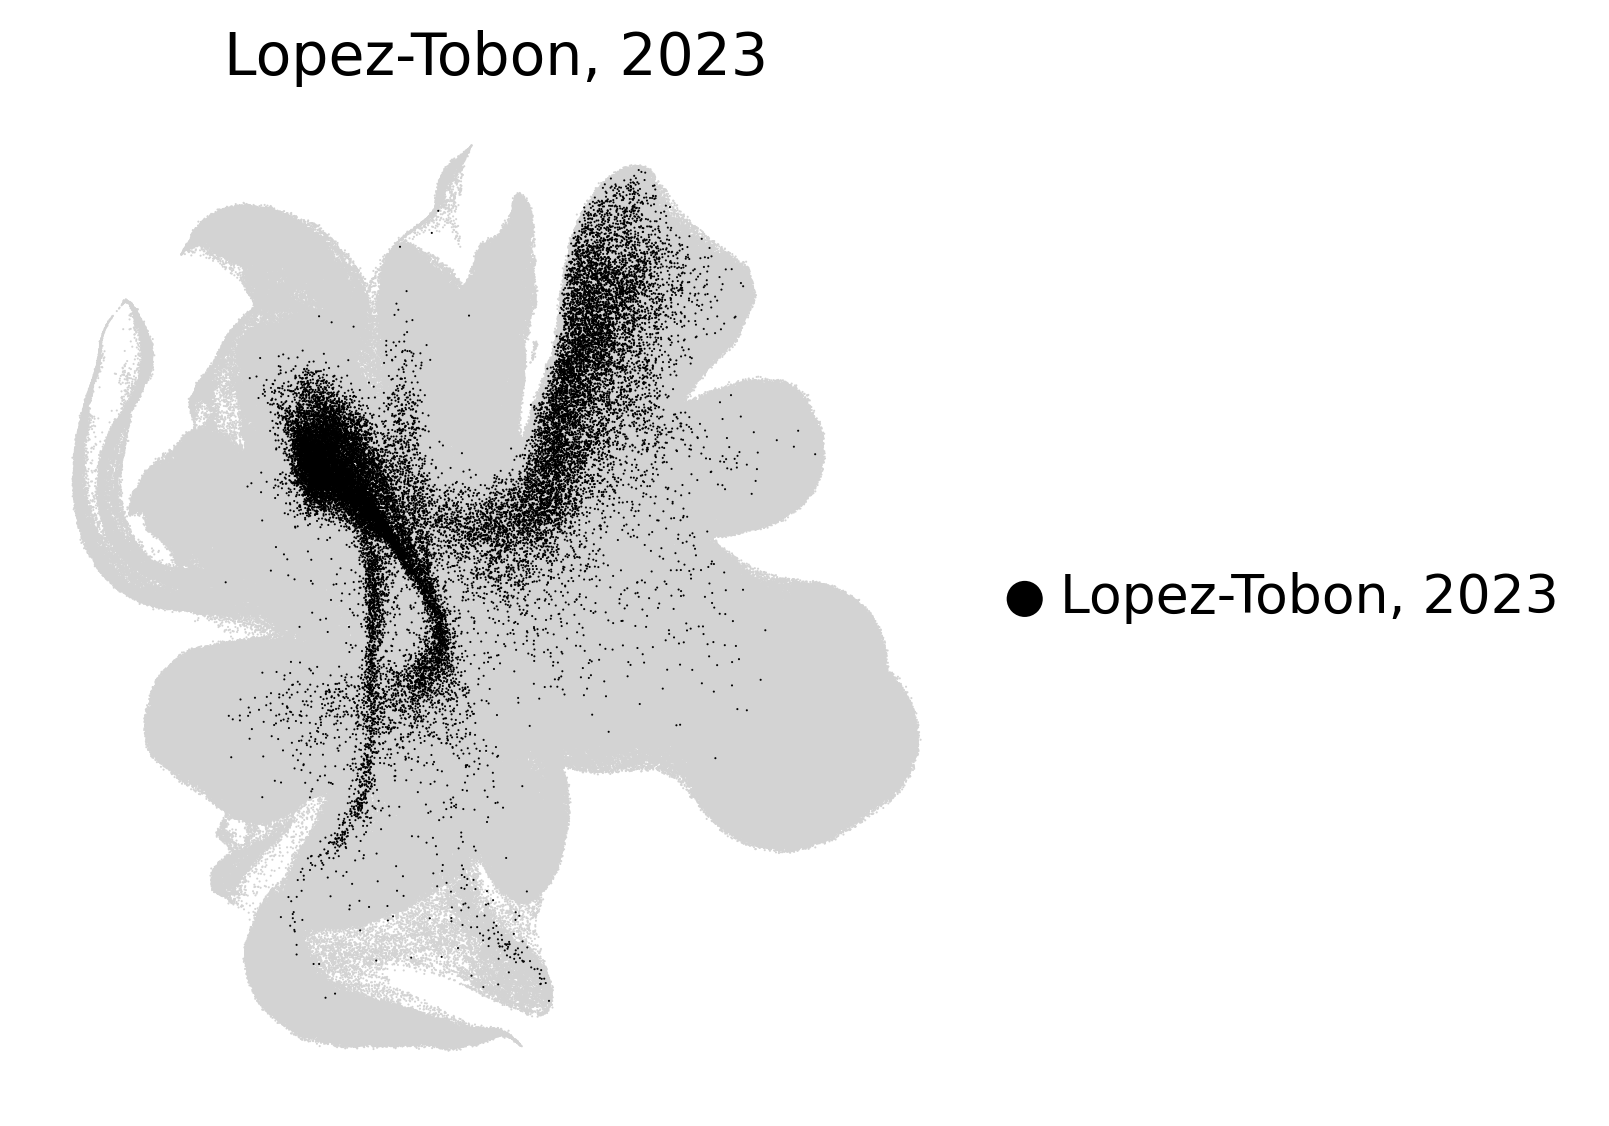

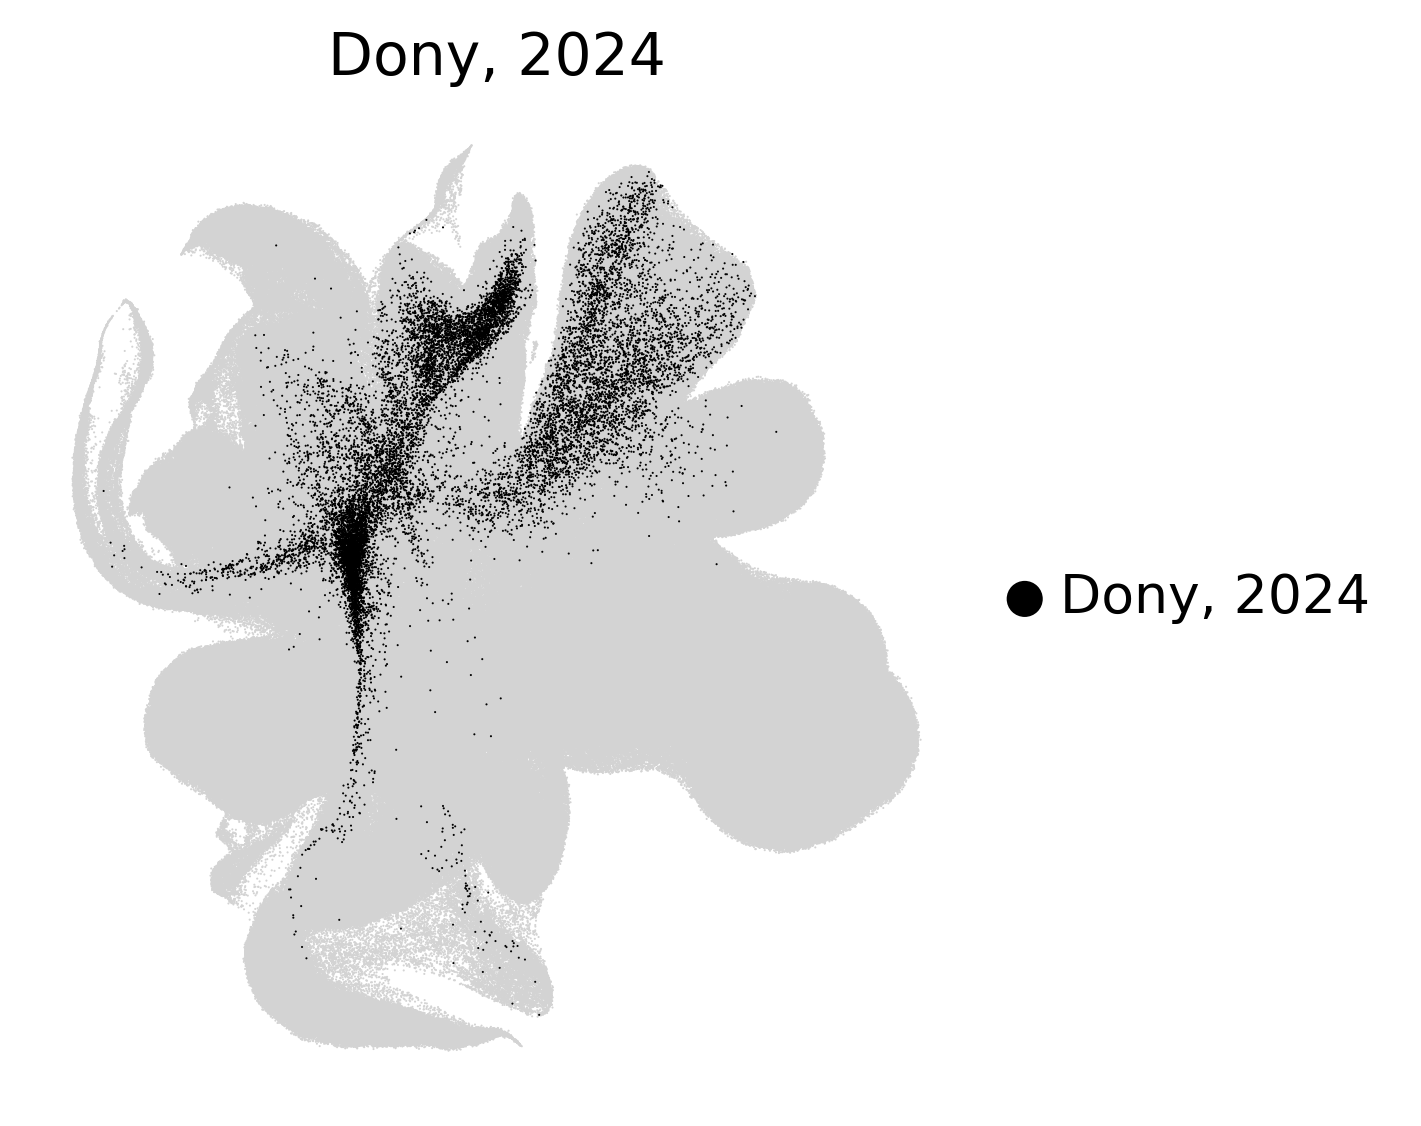

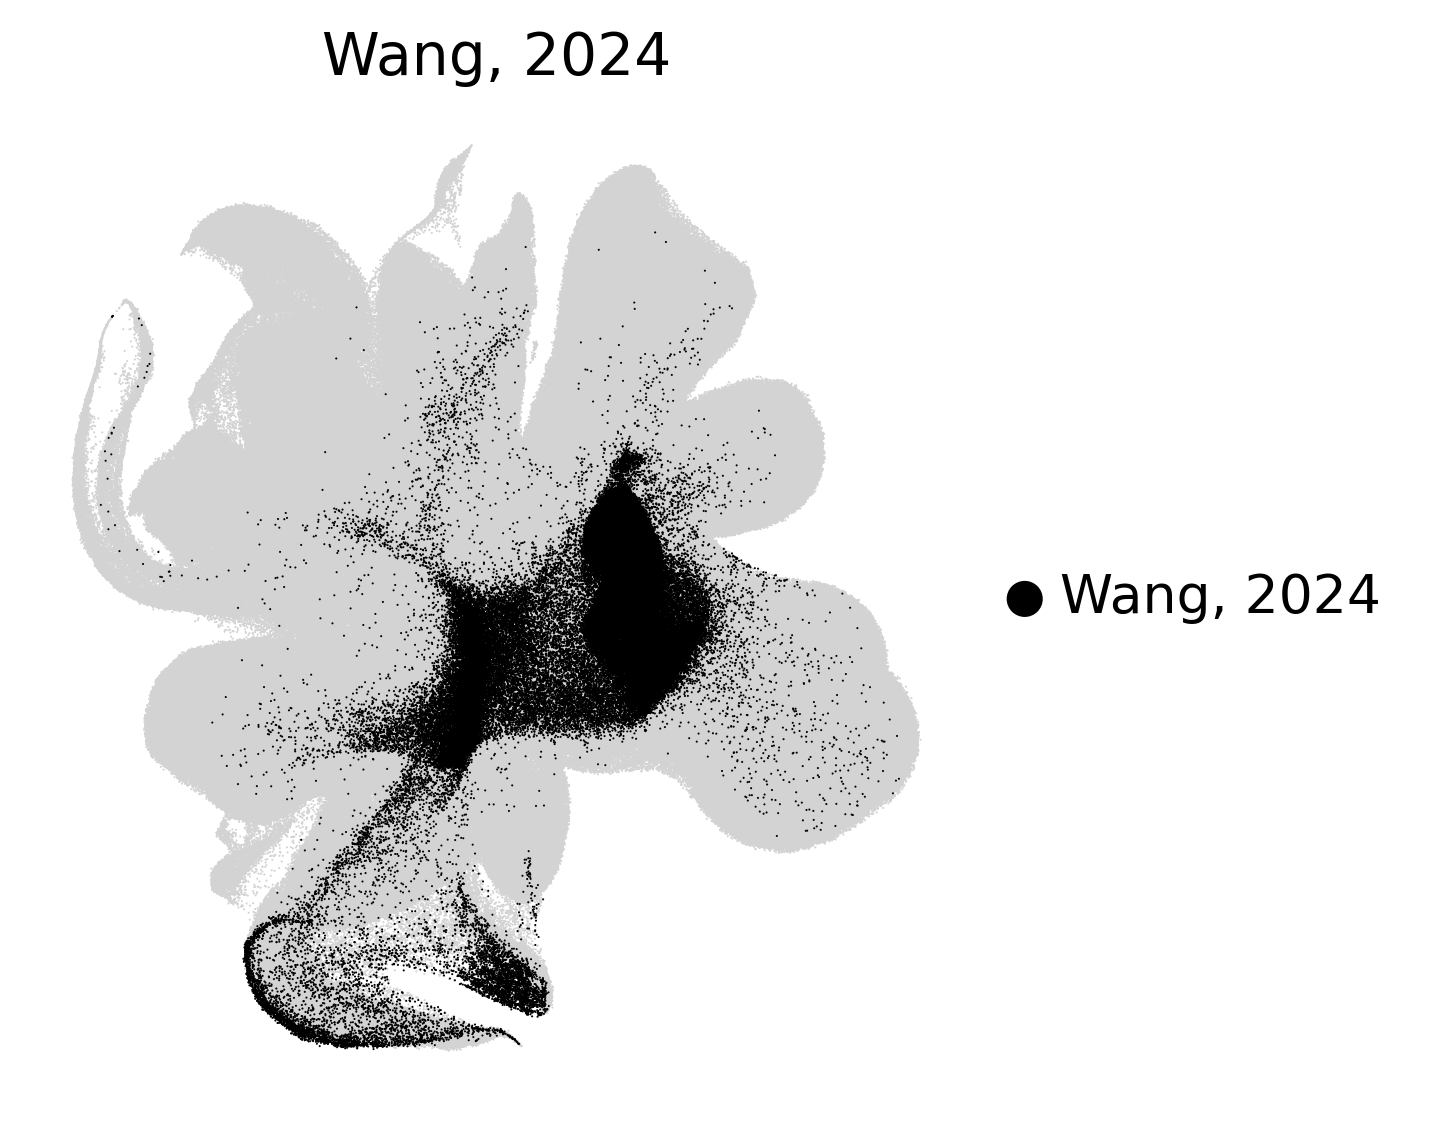

In [34]:
for i, n in enumerate(newpubs):
    sc.pl.scatter(adata_joint, basis="umap_scpoli", color="publication", groups=[n], size=1.0, palette=["#000000"], frameon=False, title=n)

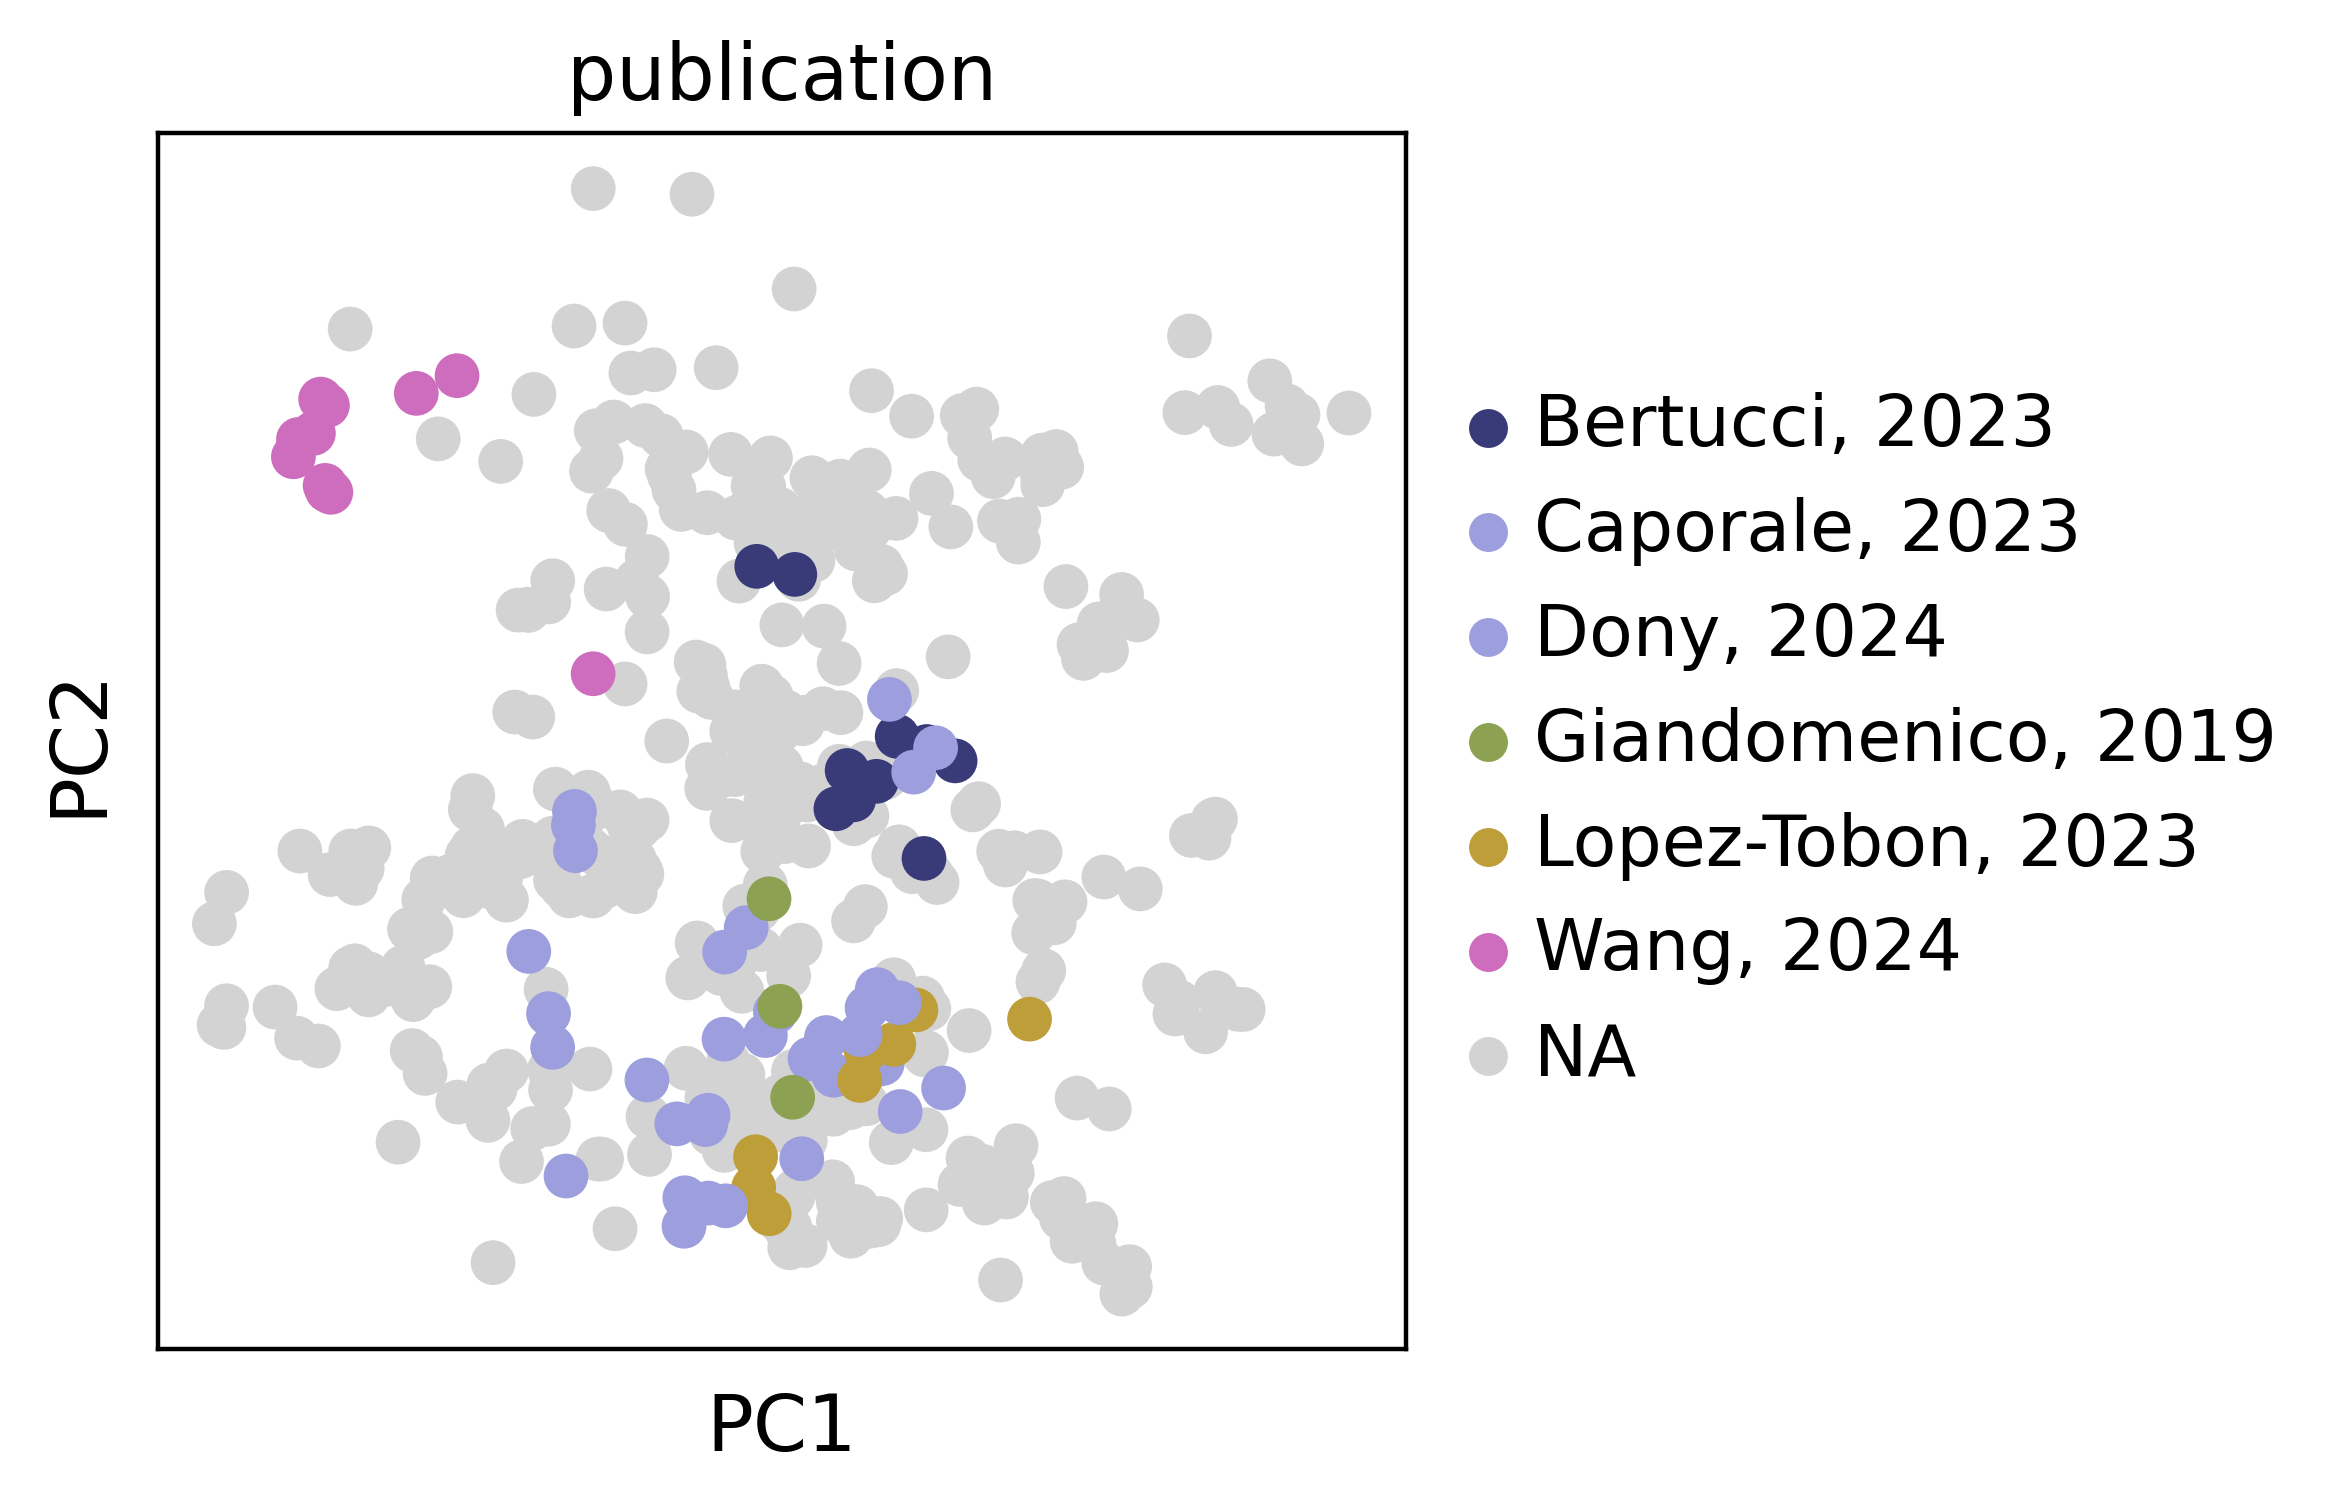

In [90]:
se = mapper2.query_model.get_conditional_embeddings()
sc.pp.pca(se)
se.obs = adata_joint.obs.groupby("batch").first().loc[se.obs.index.tolist()]
sc.pl.pca(se, color="publication", groups=newpubs, palette='tab20b')

In [51]:
adata_query_v2 = anndata.concat([adata_query_v1, adata_gd])
adata_query_v2.obs["annot_level_2_query"] = adata_joint.obs.loc[~adata_joint.obs["hnoca_core"], "annot_level_2_query"]

/home/ubuntu/venv/organoids/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


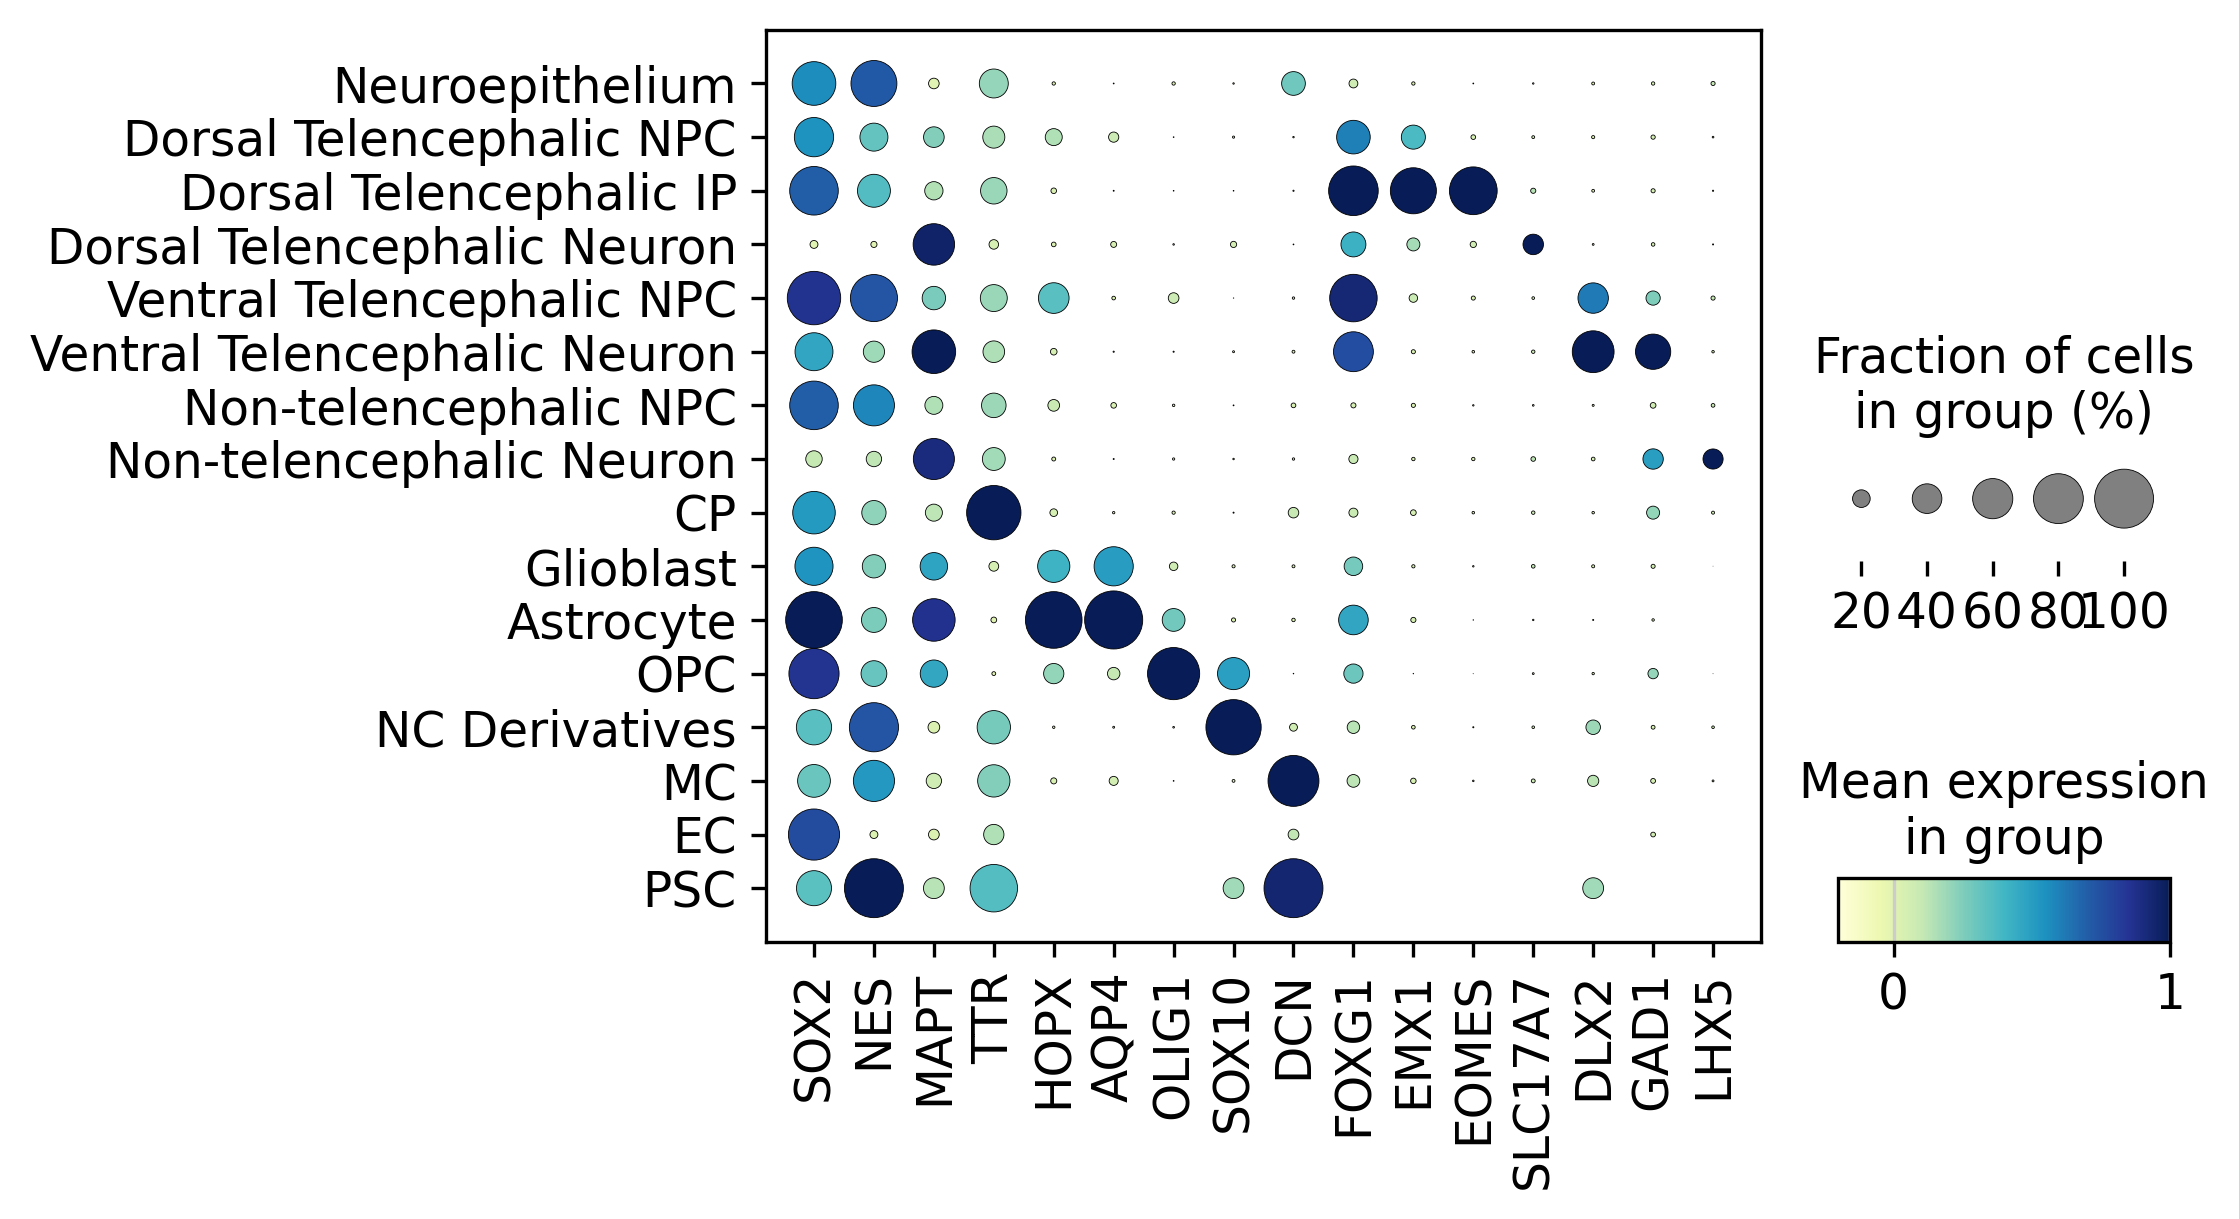

In [52]:
sc.pl.dotplot(adata_query_v2, ['SOX2','NES','MAPT','TTR','HOPX','AQP4','OLIG1','SOX10','DCN','FOXG1','EMX1','EOMES','SLC17A7','DLX2','GAD1','LHX5'],
              groupby='annot_level_2_query', cmap='YlGnBu', figsize=(6,4),
              categories_order=['Neuroepithelium','Dorsal Telencephalic NPC','Dorsal Telencephalic IP','Dorsal Telencephalic Neuron','Ventral Telencephalic NPC','Ventral Telencephalic Neuron','Non-telencephalic NPC','Non-telencephalic Neuron',
                                'CP','Glioblast','Astrocyte','OPC','NC Derivatives','MC','EC','PSC'],
              standard_scale='var', vmin=-0.2)

# Saving objects

In [36]:
adata_joint.write("/storage/data/2404_revision/ce_output/hnoca_extended_v2_joint.h5ad", compression="gzip")
adata_joint

AnnData object with n_obs × n_vars = 1984362 × 3000
    obs: 'assay_sc', 'cell_line_original', 'cell_type', 'cell_type_original', 'development_stage', 'disease', 'ethnicity', 'organ', 'organism', 'sample_source', 'sex', 'suspension_type', 'treatment', 'obs_names_original', 'organoid_age_days', 'publication', 'doi', 'batch', 'snapseed_pca_rss_level_1', 'snapseed_pca_rss_level_12', 'snapseed_pca_rss_level_123', 'hnoca_core', 'annot_level_2_query'
    uns: 'annot_level_2_query_colors', 'publication_colors'
    obsm: 'X_scpoli', 'X_umap_scpoli'
    layers: 'counts_lengthnorm'
    obsp: 'knn_scpoli_connectivities', 'knn_scpoli_distances'

In [54]:
adata_query_v2.write("/storage/data/2404_revision/ce_output/hnoca_extended_v2_query_allgenes.h5ad", compression="gzip")
adata_query_v2

AnnData object with n_obs × n_vars = 213784 × 36842
    obs: 'sample_source', 'organism', 'disease', 'cell_line_original', 'organoid_age_days', 'batch', 'treatment', 'cell_type_original', 'suspension_type', 'organ', 'assay_sc', 'ethnicity', 'sex', 'development_stage', 'cell_type', 'obs_names_original', 'publication', 'doi', 'hnoca_core', 'annot_level_2_query'
    layers: 'counts_lengthnorm'